In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

        date          Open          High           Low         Close  \
0 2008-08-08  11432.089844  11759.959961  11388.040039  11734.320312   
1 2008-08-11  11729.669922  11867.110352  11675.530273  11782.349609   
2 2008-08-12  11781.700195  11782.349609  11601.519531  11642.469727   
3 2008-08-13  11632.809570  11633.780273  11453.339844  11532.959961   
4 2008-08-14  11532.070312  11718.280273  11450.889648  11615.929688   

      Adj Close     Volume                                    headline_concat  \
0  11734.320312  212830000  b"Georgia 'downs two Russian warplanes' as cou...   
1  11782.349609  183190000  b'Why wont America and Nato help us? If they w...   
2  11642.469727  173590000  b'Remember that adorable 9-year-old who sang a...   
3  11532.959961  182550000  b' U.S. refuses Israel weapons to attack Iran:...   
4  11615.929688  159790000  b'All the experts admit that we should legalis...   

                                       reddit_concat       F_1       F_2  \
0  b

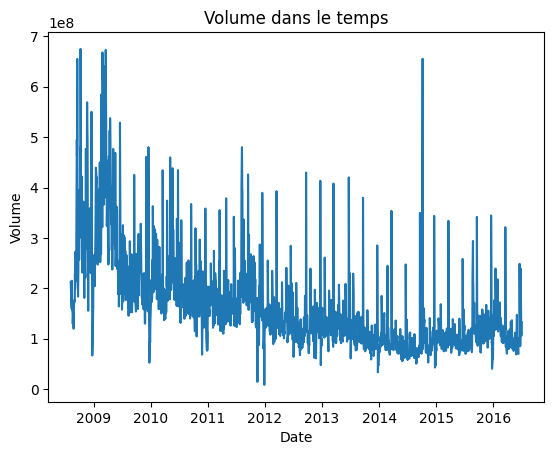

        date          Open          High           Low         Close  \
0 2008-08-08  11432.089844  11759.959961  11388.040039  11734.320312   
1 2008-08-11  11729.669922  11867.110352  11675.530273  11782.349609   
2 2008-08-12  11781.700195  11782.349609  11601.519531  11642.469727   
3 2008-08-13  11632.809570  11633.780273  11453.339844  11532.959961   
4 2008-08-14  11532.070312  11718.280273  11450.889648  11615.929688   

      Adj Close     Volume                                    headline_concat  \
0  11734.320312  212830000  b"Georgia 'downs two Russian warplanes' as cou...   
1  11782.349609  183190000  b'Why wont America and Nato help us? If they w...   
2  11642.469727  173590000  b'Remember that adorable 9-year-old who sang a...   
3  11532.959961  182550000  b' U.S. refuses Israel weapons to attack Iran:...   
4  11615.929688  159790000  b'All the experts admit that we should legalis...   

                                       reddit_concat       F_1       F_2  \
0  b

,date,Open,High,Low,Close,Adj Close,Volume,headline_concat,reddit_concat,F_1,F_2,F_3,F_4,F_5,F_6,F_7,target_updown_plus_1_days,text_index_full
0,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,11734.320312,212830000,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.'. b'Rus...,-0.306600,0.007364,0.000000,0.040111,0.029154,0.063476,0.078912,1,0.0
1,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,11782.349609,183190000,b'Why wont America and Nato help us? If they w...,"b""So this is what it's come to: trading sex fo...",-0.014951,0.008143,113.924792,0.006797,0.029727,0.251849,-0.226695,0,0.0
2,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,11642.469727,173590000,b'Remember that adorable 9-year-old who sang a...,"b""I'm Trying to Get a Sense of This Whole Geor...",0.156989,0.008199,109.168935,-0.041267,0.015027,0.196334,-0.237175,0,0.0
3,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,11532.959961,182550000,b' U.S. refuses Israel weapons to attack Iran:...,b'Witness: Russian forces head towards Tbilisi...,0.097857,0.004724,99.079503,-0.001693,-0.010083,0.175528,-0.019893,1,0.0
4,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,11615.929688,159790000,b'All the experts admit that we should legalis...,b'Taliban wages war on humanitarian aid worker...,0.239243,0.006529,176.788980,-0.051593,-0.047145,0.154382,0.051692,1,0.0


In [53]:
#df = pd.read_parquet("../data/finance_ml_dataset_clean.parquet", engine = "fastparquet")
import sys
from pathlib import Path
parent_dir = Path().resolve().parent  # dossier parent du notebook ou script
sys.path.append(str(parent_dir))
from code_weird_Arthur import df_merged
df = df_merged.copy()
# On supprime la target en valeur
df_target = df.copy()
df_target = df_target.drop(columns=["target_returns_plus_1_days"])
# Vérification
df_target.head()

In [54]:
# Séparation X et Y
# On ne prends pas en compte les variables textes

# Colonnes numériques
num_cols = ["Low", "Close", "Adj Close", "Volume", "F_1", "F_2", "F_3", "F_4", "F_5", "F_6", "F_7", "text_index_full"]

# Target
y = df["target_updown_plus_1_days"].values 

X = (df[num_cols])

In [62]:
# --- Création de séquences temporelles ---
# Les modèles LSTM ont besoin de séquences temporelles en entrée : (batch, time_steps, features)
# X normal --> le LSTM ne sait pas que les données sont ordonnées dans le temps.
# Permet au LSTM/Attention d’apprendre l’influence du passé sur le futur
# On peut tester différentes tailles de fenêtre pour trouver le meilleur compromis
# window : nombre de jours/observations à utiliser pour prédire le jour suivant
def create_sequences(X, y, window):
    X_seq, y_seq = [], []
    for i in range(window, len(X)):
        X_seq.append(X[i-window:i])  # vecteurs de features sur plusieurs jours consécutifs
        y_seq.append(y[i])           # target du jour suivant
    return np.array(X_seq), np.array(y_seq)

# --- Définition d'une couche d'attention personnalisée ---
# Chaque timestep reçoit un poids relatif selon son importance pour la prédiction
# La couche renvoie un vecteur de contexte : résumé pondéré des timesteps
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()
        self.dense = Dense(1)  # couche Dense qui calcule un score d’importance pour chaque timestep

    def call(self, inputs, return_attention=False):
        score = tf.nn.softmax(self.dense(inputs), axis=1)  # normalise les scores sur la dimension temporelle
        context = tf.reduce_sum(score * inputs, axis=1)    # vecteur résumé pondéré
        if return_attention:
            return context, score
        return context

# --- Définition du modèle LSTM + Attention ---
def create_model(n_timesteps, n_features):
    inputs = Input(shape=(n_timesteps, n_features))
    x = LSTM(64, return_sequences=True)(inputs)  # LSTM nécessaire pour combiner les timesteps
    x = Dropout(0.2)(x)                          # régularisation pour réduire l'overfitting
    att = Attention()(x)                          # attention sur tous les timesteps
    x = Dense(32, activation="selu")(att)        # dense pour combiner les informations (on pourrait tester selu, tanh, gelu)
    output = Dense(1, activation="sigmoid")(x)   # sigmoid pour obtenir une probabilité entre 0 et 1
    model = Model(inputs, output)
    model.compile(optimizer="adam", 
                  loss="binary_crossentropy",  # perte adaptée pour classification binaire
                  metrics=["accuracy"])
    return model

In [63]:
# --- Liste de fenêtres temporelles à tester ---
windows = [10, 20, 30, 50, 60]  
results = {}

for window in windows:
    print(f"\n=== Fenêtre temporelle = {window} ===")
    X_seq, y_seq = create_sequences(X, y, window)  # Création des séquences selon la fenêtre testée
    n_timesteps = X_seq.shape[1]
    n_features = X_seq.shape[2]

    tscv = TimeSeriesSplit(n_splits=5)
    y_pred_all = []  # liste pour stocker toutes les prédictions
    y_true_all = []  # pour stocker les vraies valeurs correspondantes
    acc_list = []
    roc_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for train_idx, test_idx in tscv.split(X_seq):
        X_train, X_test = X_seq[train_idx], X_seq[test_idx]
        y_train, y_test = y_seq[train_idx], y_seq[test_idx]

        # --- Scaling sur le fold ---
        scaler = StandardScaler()
        X_train_2d = X_train.reshape(-1, n_features)
        X_test_2d = X_test.reshape(-1, n_features)
        X_train_scaled = scaler.fit_transform(X_train_2d).reshape(-1, n_timesteps, n_features)
        X_test_scaled = scaler.transform(X_test_2d).reshape(-1, n_timesteps, n_features)
# Les LSTM fonctionnent mieux sur des données centrées et normalisées.
# Reshape en 2D pour que StandardScaler puisse transformer chaque feature.
# Puis on reforme en 3D pour l’entrée LSTM.

        # --- Création et entraînement du modèle ---
        model = create_model(n_timesteps, n_features)
        model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test),
                  epochs=10, batch_size=32, verbose=0)

        # --- Prédiction sur le fold ---
        y_pred = (model.predict(X_test_scaled) > 0.5).astype(int) # probabilités transformées en 0/1 avec un seuil de 0.5

        # --- Stockage des prédictions et des vraies valeurs ---
        # Concaténation des prédictions de chaque fold
        y_pred_all.extend(y_pred.flatten())  # On accumule dans la liste
        y_true_all.extend(y_test.flatten())  # Idem pour les vraies valeurs

        # --- Calcul des métriques du fold ---
        acc_list.append(accuracy_score(y_test, y_pred))
        roc_list.append(roc_auc_score(y_test, y_pred))
        precision_list.append(precision_score(y_test, y_pred, average="macro")) # moyenne des métriques sur les classes pour gérer les déséquilibres
        recall_list.append(recall_score(y_test, y_pred, average="macro"))
        f1_list.append(f1_score(y_test, y_pred, average="macro"))

    # --- Conversion en arrays après avoir accumulé toutes les prédictions ---
    y_pred_all = np.array(y_pred_all)
    y_true_all = np.array(y_true_all)

    # --- Calcul des métriques globales pour la fenêtre ---
    print("=== Métriques globales pour la fenêtre ===")
    print("Accuracy:", accuracy_score(y_true_all, y_pred_all))
    print("Precision:", precision_score(y_true_all, y_pred_all, average="macro"))
    print("Recall:", recall_score(y_true_all, y_pred_all, average="macro"))
    print("F1-score:", f1_score(y_true_all, y_pred_all, average="macro"))
    print("ROC-AUC:", roc_auc_score(y_true_all, y_pred_all))

    # --- Matrice de confusion globale ---
    cm = confusion_matrix(y_true_all, y_pred_all)
    print("Confusion Matrix:")
    print(cm)

    # --- Rapport de classification complet ---
    print("\nClassification Report:")
    print(classification_report(y_true_all, y_pred_all))



=== Fenêtre temporelle = 10 ===
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


c:\Users\isali\Documents\cours\M2_ECAP\Deep Learning\projet_deep_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
=== Métriques globales pour la fenêtre ===
Accuracy: 0.5088145896656535
Precision: 0.49010924387938437
Recall: 0.49184339557523177
F1-score: 0.4754282105927855
ROC-AUC: 0.4918433955752318
Confusion Matrix:
[[211 546]
 [262 626]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.28      0.34       757
           1       0.53      0.70      0.61       888

    accuracy                           0.51      1645
   macro avg       0.49      0.49      0.48      1645
weighted avg       0.49      0.51      0.49      1645


=== Fenêtre temporelle = 20 ===
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


c:\Users\isali\Documents\cours\M2_ECAP\Deep Learning\projet_deep_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


c:\Users\isali\Documents\cours\M2_ECAP\Deep Learning\projet_deep_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
=== Métriques globales pour la fenêtre ===
Accuracy: 0.5009174311926605
Precision: 0.48779828341746984
Recall: 0.48885636591954174
F1-score: 0.48193111675111133
ROC-AUC: 0.48885636591954174
Confusion Matrix:
[[253 500]
 [316 566]]

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.34      0.38       753
           1       0.53      0.64      0.58       882

    accuracy                           0.50      1635
   macro avg       0.49      0.49      0.48      1635
weighted avg       0.49      0.50      0.49      1635


=== Fenêtre temporelle = 30 ===
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


c:\Users\isali\Documents\cours\M2_ECAP\Deep Learning\projet_deep_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


c:\Users\isali\Documents\cours\M2_ECAP\Deep Learning\projet_deep_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
=== Métriques globales pour la fenêtre ===
Accuracy: 0.5193846153846153
Precision: 0.505239771965124
Recall: 0.5044761904761905
F1-score: 0.49189087259247455
ROC-AUC: 0.5044761904761905
Confusion Matrix:
[[233 517]
 [264 611]]

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.31      0.37       750
           1       0.54      0.70      0.61       875

    accuracy                           0.52      1625
   macro avg       0.51      0.50      0.49      1625
weighted avg       0.51      0.52      0.50      1625


=== Fenêtre temporelle = 50 ===
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


c:\Users\isali\Documents\cours\M2_ECAP\Deep Learning\projet_deep_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


c:\Users\isali\Documents\cours\M2_ECAP\Deep Learning\projet_deep_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
=== Métriques globales pour la fenêtre ===
Accuracy: 0.5124223602484472
Precision: 0.5028659785691775
Recall: 0.5027114790605797
F1-score: 0.4992628702536749
ROC-AUC: 0.5027114790605797
Confusion Matrix:
[[282 459]
 [326 543]]

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.38      0.42       741
           1       0.54      0.62      0.58       869

    accuracy                           0.51      1610
   macro avg       0.50      0.50      0.50      1610
weighted avg       0.51      0.51      0.51      1610


=== Fenêtre temporelle = 60 ===
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\isali\Documents\cours\M2_ECAP\Deep Learning\projet_deep_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\isali\Documents\cours\M2_ECAP\Deep Learning\projet_deep_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
=== Métriques globales pour la fenêtre ===
Accuracy: 0.50375
Precision: 0.48645373879764464
Recall: 0.4884713812335339
F1-score: 0.4747426635971527
ROC-AUC: 0.4884713812335339
Confusion Matrix:
[[215 523]
 [271 591]]

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.29      0.35       738
           1       0.53      0.69      0.60       862

    accuracy                           0.50      1600
   macro avg       0.49      0.49      0.47      1600
weighted avg       0.49      0.50      0.48      1600



In [ ]:
# Interprétation des résultats : 
# Accuracy : la fenêtre de 30 jours est la plus performante (0.519), légèrement meilleure que 50 jours (0.512)
# Precision et Recall : également maximales pour 30 jours
# F1-score : reflète l’équilibre precision/recall, encore une fois meilleure pour 30 jours
# ROC-AUC : 0.504 pour 30 jours, légèrement au-dessus des autres
# fenêtre optimale = 30 jours 
# -> compromis correct entre capacité du modèle à utiliser le contexte historique et performance générale

# fenêtres courtes -> manque d'informations et de contexte
# fenêtres longues -> trop de bruits, apprentissage plus difficile

# Matrice de confusion : 
# [[233 517]
# [264 611]]
# Classe 0 (négative) : 233 correctement prédits, 517 mal classés comme 1 (beaucoup de faux positifs)
# Classe 1 (positive) : 611 correctement prédits, 264 mal classés comme 0 (faux négatifs moins nombreux que les faux positifs)